# Introduction  <a id='introduction'></a>

In [Multivariate Linear Regression From Scratch](https://www.kaggle.com/code/erkanhatipoglu/multivariate-linear-regression-from-scratch) notebook, we have seen how to utilize the gradient descent algorithm to solve a multiple linear regression task. We have used the negative gradient of the cost function j(θ) and taken tiny steps to calculate the θ vector that minimizes j(θ) to find the best linear fit for our data. Yet, we may have an alternative analytical solution called the 'normal equation' for a linear regression task.

We will first explain the 'normal equation' and compare it with gradient descent to identify the advantages and limitations. Then, we will use the dataset we used in the [Multivariate Linear Regression From Scratch](https://www.kaggle.com/code/erkanhatipoglu/multivariate-linear-regression-from-scratch) notebook to find the θ vector using the 'normal equation.' We will then validate our data with the same validation data we used earlier and compare the results. Interested Kagglers may refer to the [References](#references) section for my works on linear regression for more detailed explanations.  

This notebook is greatly inspired by the famous Machine Learning course by [Andrew Ng](https://www.andrewng.org/). All the mistakes, if any, are made by me.

Finally, thanks to [@Mohan S Acharya](https://www.kaggle.com/mohansacharya) for this dataset.


# Table of Contents
* [Introduction](#introduction)
* [Helper functions](#functions)
* [The Normal Equation](#normal)
* [The Hypothesis](#hypothesis)
* [The Cost Function](#cost)
* [Loading Data](#getdata)
* [Model Training](#training)
* [Model Validation](#validation)
* [Conclusion](#conclusion)
* [References](#references)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn.model_selection import train_test_split
from numpy import linalg
import matplotlib.pyplot as plt

/kaggle/input/graduate-admissions/Admission_Predict.csv
/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv


# Helper Functions   <a id='functions'></a>   

<div class="alert alert-block alert-info">
<b>Tip:</b> We will use some helper functions throughout the notebook. Collecting them in one place is a good idea, making the code more organized. First, we will define and explain those functions and then use them in our code.
</div>

# The Normal Equation   <a id='normal'></a> 

As we all know, gradient descent is an iterative algorithm that must be conducted repeatedly until convergence. Especially for a small number of features, alternatively, we may use a much faster method called the 'normal equation.' The idea is as follows:

We know that for a function of f(θ), the θ values that make the derivative of f(θ) zero are the maximum or minimum point for f(θ). For our specific squared error cost function, it turns out that this is the minimum point. We can understand this by the following figure:

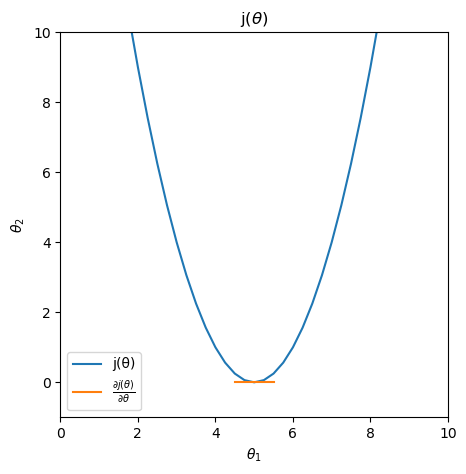

In [2]:
x = np.arange(-20, 20, 0.25)
y = (x-5)**2

plt.figure(figsize=(5, 5))

plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title(r'j($\theta$)')

plt.xlim(0, 10)
plt.ylim(-1, 10)

plt.plot(x, y, label='j(θ)')

p1 = [4.5, 5.5]
p2 = [0, 0]

plt.plot(p1, p2, label=r'$\frac{\partial j(θ)}{\partial θ}$')

plt.legend()

plt.show()

Suppose we have a squared error cost function j(θ), as the plot above shows. As can be seen, the derivate of j(θ) at the global minimum is zero. So if we find the θ values that make the derivative of the cost function j(θ) zero, we can use them for the optimal solution. We know that j(θ) in vectorized form can be written as follows:

$ J(\theta) = \frac{1}{2m}( X\theta - \vec y)^T(X\theta - \vec y) $

Therefore,

$\frac{\partial J(\theta)}{\partial \theta} = \frac{\partial}{\partial \theta} \frac{1}{2m}( X\theta - \vec y)^T(X\theta - \vec y) := 0 $

If we solve the equation above for θ, we get the following:

$ \boldsymbol{\theta} := (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{\vec y}  $

We must calculate the inverse of matrix $\boldsymbol{X}^T \boldsymbol{X}$, which has dimensions (n+1 X n+1), to find the θ values. Unfortunately, not every matrix has an inverse. So we must be careful while taking the inverse. Too many (m>=n, where m is the number of examples and n is the number of features) or redundant features may cause $\boldsymbol{X}^T \boldsymbol{X}$ to be non-invertible. If we run across a non-invertible matrix case, we may attempt to decrease the features or get more data to solve the issue. 

Also, the [NumPy library](https://numpy.org/doc/stable/index.html) has a function called [pinv()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) that will compute the pseudo-inverse of $\boldsymbol{X}^T \boldsymbol{X}$ so that even if $\boldsymbol{X}^T \boldsymbol{X}$ is non-invertible, we may have a solution. 

We get the following table if we compare the 'normal equation' approach with the gradient descent approach [[1](https://www.deeplearning.ai/program/machine-learning-specialization/)].

|Gradient Descent                           |Normal Equation                                                                 |
|:------------------------------------------|:-------------------------------------------------------------------------------|
|Need to choose alpha                       |No need to choose alpha                                                         |
|Needs many iterations                      |No need to iterate                                                              |
|$O(n^2)$                                   |$O(n^3)$, need to calculate $(\boldsymbol{X}^T \boldsymbol{X})^{-1}$            |
|Works well when n is large                 |Slow if n is very large                                                         |

In [3]:
# The normal equation

def calculate_theta(X,y):
    """
     Calculates the theta vector using the normal equation.
    
    :param X: inputs (feature values) - data frame of floats
    :param y: outputs (actual target values) - Numpy array of floats
    
    :return: new theta - Numpy array of floats
    
    """
    # Calculate transpose of X
    X_transpose = X.transpose()
    
    # Calculate the dot product between X_transpose and X
    temp_0 = np.dot(X_transpose, X)
        
    # Calculate the inverse of temp_0
    try:
        temp_1 = linalg.inv(temp_0)
     
    except:
        print("\033[93mWarning: Non-invertible Matrix! pinv() will be used\033[0m")
        temp_1 = linalg.pinv(temp_0)

    # Calculate the dot product between temp_1 and X_transpose
    temp_2 = np.dot(temp_1, X_transpose)

    # Calculate the dot product between temp_2 and y
    theta = np.dot(temp_2, y) 

    return  theta.reshape(-1)

# The  Hypothesis   <a id='hypothesis'></a>   

The vectorized form of the hypothesis for linear regression is:

$ h_\theta(x) = \boldsymbol{X}\boldsymbol{\theta} $

You can refer to [Multivariate Linear Regression From Scratch](https://www.kaggle.com/code/erkanhatipoglu/multivariate-linear-regression-from-scratch) notebook for more detailed information.

In [4]:
# The hypothesis
def h(x, theta):
    """
     Calculates the predicted values (or predicted targets) for a given set of input and theta vectors.
    
    :param x: inputs (feature values) - data frame of floats 
    :param theta: theta vector (weights) - Numpy array of floats
    
    :return: predicted targets - Numpy array of floats
    
    """
    # The hypothesis is a column vector of m x 1
    return np.dot(x, theta)

# The  Cost Function   <a id='cost'></a> 

The cost Function Text!

In [5]:
# The cost function

def J(X,y,theta):
    """
     Calculates the total error using squared error function.
    
    :param X: inputs (feature values) - data frame of floats
    :param y: outputs (actual target values) - Numpy array of floats
    :param theta: theta vector (weights) - Numpy array of floats
    
    :return: total error - float
    
    """
    # Calculate number of examples
    m = len(X)
    
    # Calculate the constant
    c = 1/(2 * m)
       
    # Calculate the array of errors
    temp_0 = h(X, theta) - y.reshape(-1)

    # Calculate the transpose of array of errors
    temp_1 = temp_0.transpose()

    # Calculate the dot product 
    temp_2 = np.dot(temp_1, temp_0) 

    return  c * temp_2

# Loading Data   <a id='getdata'></a> 

First of all, we will load the CSV file in this part. Since there are two different versions of the dataset, we will load the one with more data. We will then create our training DataFrame and target vector. Next, we will normalize some columns of the training DataFrame using min-max scaling. Finally, we will split our data into training and validation DataFrames so that we can validate the results.

In [6]:
# Get the data. Note that there are two versions. We will use the one
# with the most rows.

train_data = pd.read_csv("/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv")

# Set X and y
X = train_data.drop(['Chance of Admit ', 'Serial No.'], axis=1) # Chance of Admit is the target variable and Serial No. is the order. So we drop them.
y = pd.DataFrame(data = train_data['Chance of Admit ']).to_numpy()

# Instead of finding probabilities, we want to calculate the percentages.
y = y * 100

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 0)

X_train.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
107,338,117,4,3.5,4.5,9.46,1
336,319,110,3,3.0,2.5,8.79,0
71,336,112,5,5.0,5.0,9.76,1
474,308,105,4,3.0,2.5,7.95,1
6,321,109,3,3.0,4.0,8.20,1


# Model Training   <a id='training'></a> 

Model Training Text!

In [7]:
# Initialize

# Calculate the number of examles
m_train = len(X_train)
m_valid = len(X_valid)

# Calculate the number of features
# including X_0
n = len(X_train.axes[1]) + 1

# Create a list of ones
ones_train = [1] * m_train
ones_valid = [1] * m_valid

# Insert ones to the fist column since
# X_0 for all training examples should
# be one.
X_train.insert(0, "X_0", ones_train, True)
X_valid.insert(0, "X_0", ones_valid, True)

# Find the theta vector using the normal equation
theta_train = calculate_theta(X_train,y_train)
print("\nCalculated\033[1m θ\033[0m: {}\n".format(theta_train))

# Calculate and display the cost value on the training dataset
cost_train = J(X_train, y_train, theta_train)
print("The training cost is: {}".format(cost_train))


Calculated θ: [-1.34416734e+02  2.14141419e-01  2.77038677e-01  5.55692827e-01
  5.10313673e-02  2.04133847e+00  1.15053979e+01  2.41256700e+00]

The training cost is: 17.100414719720018


# Model Validation   <a id='validation'></a> 

Model Validation Text

In [8]:
print("\nCalculated\033[1m θ\033[0m: {}\n".format(theta_train))

cost_valid = J(X_valid, y_valid, theta_train)
print("The validation cost is: {}".format(cost_valid))


Calculated θ: [-1.34416734e+02  2.14141419e-01  2.77038677e-01  5.55692827e-01
  5.10313673e-02  2.04133847e+00  1.15053979e+01  2.41256700e+00]

The validation cost is: 20.39840017300976


The cost of the validation dataset seems slightly bigger (worse) than the training dataset, which is expected. We can also see the validation results below:

In [9]:
# Compare actual results with predicted results
result = pd.DataFrame(index=X_valid.index)
result['Actual CoA'] = y_valid
result['Predicted CoA'] = h(X_valid, theta_train)
result.head()

,Actual CoA,Predicted CoA
90,64.0,66.062520
254,85.0,83.467888
283,80.0,77.803235
445,91.0,88.054515
461,68.0,60.126564


# Conclusion   <a id='conclusion'></a> 

Conclusion Text!

# References   <a id='references'></a>
[1] - [Machine Learning Specialization - Deeplearning.AI](https://www.deeplearning.ai/program/machine-learning-specialization/)

[2] - [Andrew Ng](https://en.wikipedia.org/wiki/Andrew_Ng)

[3] - [@Mohan S Acharya](https://www.kaggle.com/mohansacharya)

[4] - [Multivariate Linear Regression From Scratch - Kaggle](https://www.kaggle.com/code/erkanhatipoglu/multivariate-linear-regression-from-scratch)

[5] - [Univariate Linear Regression From Scratch - Kaggle](https://www.kaggle.com/code/erkanhatipoglu/univariate-linear-regression-from-scratch)

[6] - [Univariate Linear Regression From Scratch - Towards AI](https://pub.towardsai.net/univariate-linear-regression-from-scratch-68065fe8eb09)

[7] - [Multivariate Linear Regression From Scratch - Towards AI](https://medium.com/towards-artificial-intelligence/multivariate-linear-regression-from-scratch-c6702e26cce0https://medium.com/towards-artificial-intelligence/multivariate-linear-regression-from-scratch-c6702e26cce0)

[8] - [Towards AI](https://pub.towardsai.net/)